# Multi-qubit: GHZ phase estimation
In this example, we define a circuit to prepare a GHZ state. This state, ubiquitous in quantum information processing tasks, is highly entangled; and in the context of quantum metrology, saturates the Heisenberg limit.

In [1]:
import itertools
import jax 

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.base import SharedGate
from squint.ops.dv import Conditional, DiscreteVariableState, HGate, RZGate, XGate

In [3]:
n = 3  # number of qubits
circuit = Circuit(backend="pure")
for i in range(n):
    circuit.add(DiscreteVariableState(wires=(i,), n=(0,)))

circuit.add(HGate(wires=(0,)))
for i in range(n - 1):
    circuit.add(Conditional(gate=XGate, wires=(i, i + 1)))

circuit.add(
    SharedGate(op=RZGate(wires=(0,), phi=0.0 * jnp.pi), wires=tuple(range(1, n))),
    "phase",
)

for i in range(n):
    circuit.add(HGate(wires=(i,)))

pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteVariableState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   DiscreteVariableState(wires=(1,), n=[(1.0, (0,))]),
│   2:
│   DiscreteVariableState(wires=(2,), n=[(1.0, (0,))]),
│   3:
│   HGate(wires=(0,)),
│   4:
│   Conditional(wires=(0, 1), gate=XGate(wires=(1,))),
│   5:
│   Conditional(wires=(1, 2), gate=XGate(wires=(2,))),
│   'phase':
│   SharedGate(
│     wires=(0, 1, 2),
│     op=RZGate(wires=(0,), phi=weak_f64[]),
│     copies=[RZGate(wires=(1,), phi=None), RZGate(wires=(2,), phi=None)],
│     where=<function <lambda>>,
│     get=<function <lambda>>
│   ),
│   7:
│   HGate(wires=(0,)),
│   8:
│   HGate(wires=(1,)),
│   9:
│   HGate(wires=(2,))
  },
  _backend='pure'
)

In [11]:
get = lambda pytree: jnp.array([pytree.ops["phase"].op.phi])
params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = circuit.compile(params, static, dim=2, optimize="greedy")

In [14]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)

def update(phi, params):
    return eqx.tree_at(lambda pytree: pytree.ops["phase"].op.phi, params, phi)
    
probs = jax.lax.map(lambda phi: sim.probabilities.forward(update(phi, params)), phis)
grads = jax.lax.map(lambda phi: get(sim.probabilities.grad(update(phi, params))), phis)
qfims = jax.lax.map(lambda phi: sim.amplitudes.qfim(get, update(phi, params)), phis)
cfims = jax.lax.map(lambda phi: sim.probabilities.cfim(get, update(phi, params)), phis)


[Text(0.5, 0, 'Phase, $\\varphi$'), Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$')]

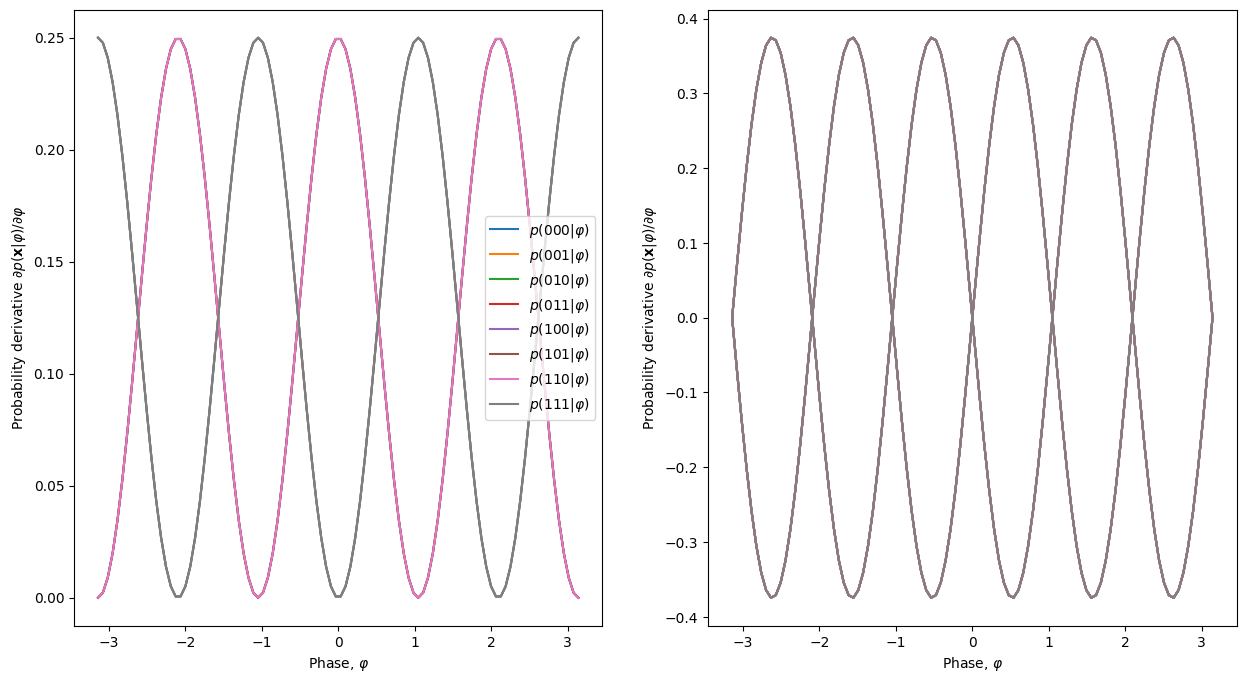

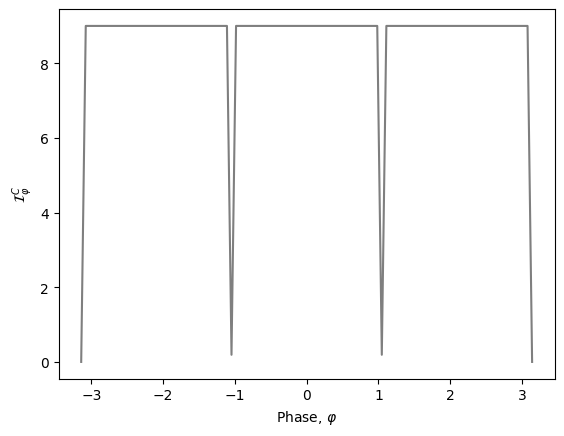

In [15]:
colors = sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, axs = plt.subplots(ncols=2, figsize=[15, 8])
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    axs[0].plot(
        phis,
        probs[:, *idx],
        label=f"$p({''.join(map(str, idx))}" + r"|\varphi)$",
        color=colors[i],
    )
    axs[1].plot(
        phis,
        grads[:, *idx],
        label=r"$\partial"
        + f"p({''.join(map(str, idx))}"
        + r"|\varphi) / \partial \varphi$",
        color=colors[i],
    )

axs[0].legend()
for ax in axs:
    ax.set(
        xlabel=r"Phase, $\varphi$",
        ylabel=r"Probability derivative $\partial p(\mathbf{x} | \varphi) / \partial \varphi$",
    )


fig, ax = plt.subplots()
ax.plot(phis, cfims.squeeze(), color=colors[i])
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"$\mathcal{I}_\varphi^C$")